In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

In [2]:
model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [3]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [4]:
from keras import backend as k

In [5]:
with open('mnist_raw_data.npy', 'rb') as f:
    raw_data = np.load(f, allow_pickle=True, encoding = 'latin1')
raw_data.shape

(55000, 28, 28, 1)

In [6]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [7]:
with open('mnist_label_data.npy', 'rb') as f:
    label_data = np.load(f, allow_pickle=True, encoding = 'latin1')
label_data.shape

(55000, 10)

In [9]:
model.fit(raw_data ,label_data, steps_per_epoch = 10, epochs = 42)

Epoch 1/42
10/10 [==============================] - 4s 443ms/step - loss: 2.2296 - accuracy: 0.4067
Epoch 2/42
10/10 [==============================] - 5s 476ms/step - loss: 1.8092 - accuracy: 0.6850
Epoch 3/42
10/10 [==============================] - 5s 475ms/step - loss: 0.9982 - accuracy: 0.7815
Epoch 4/42
10/10 [==============================] - 5s 504ms/step - loss: 0.5209 - accuracy: 0.8483
Epoch 5/42
10/10 [==============================] - 5s 523ms/step - loss: 0.3535 - accuracy: 0.8929
Epoch 6/42
10/10 [==============================] - 5s 535ms/step - loss: 0.2719 - accuracy: 0.9194
Epoch 7/42
10/10 [==============================] - 5s 526ms/step - loss: 0.2264 - accuracy: 0.9329
Epoch 8/42
10/10 [==============================] - 5s 525ms/step - loss: 0.1957 - accuracy: 0.9416
Epoch 9/42
10/10 [==============================] - 5s 541ms/step - loss: 0.1742 - accuracy: 0.9478
Epoch 10/42
10/10 [==============================] - 5s 537ms/step - loss: 0.1608 - accuracy: 0.9513

In [11]:
from keras.models import Model
import tensorflow as tf

y = model.output

row_idx = tf.range(tf.shape(y)[0])
col_idx = tf.argmax(y, axis=1, output_type=tf.dtypes.int32)
full_indices = tf.stack([row_idx, col_idx], axis=1)
fx_tensors = tf.gather_nd(y, full_indices)

x_tensors = model.trainable_weights

num_samples = 100
m = Model(inputs=model.input, outputs=fx_tensors)

fisher_information = []
for v in range(len(x_tensors)):
    fisher_information.append(np.zeros(x_tensors[v].get_shape().as_list()).astype(np.float32))

for i in range(num_samples):
    data_idx = np.random.randint(raw_data.shape[0])
    sampled_data = raw_data[data_idx:data_idx+1]
    sampled_input_variables = [ sampled_data ]
    print ('sample num: %4d, data_idx: %5d' % (i, data_idx))

    with tf.GradientTape() as tape:
        p = m(sampled_data)
        lo = tf.math.log(p)

    gradients = tape.gradient(lo, x_tensors)
    derivatives = [g.numpy() for g in gradients]
    prob = p.numpy()[0]
    
#     derivatives, prob = sess.run([tf.gradients(tf.log(fx_tensors), x_tensors), fx_tensors],
#     feed_dict={t: v for t,v in zip(input_tensors, sampled_input_variables)})

    for v in range(len(fisher_information)):
        fisher_information[v] += np.square(derivatives[v]) * prob

for v in range(len(fisher_information)):
    fisher_information[v] /= num_samples

sample num:    0, data_idx: 36031
sample num:    1, data_idx:  3416
sample num:    2, data_idx: 31734
sample num:    3, data_idx: 39860
sample num:    4, data_idx: 31878
sample num:    5, data_idx: 41533
sample num:    6, data_idx:  1757
sample num:    7, data_idx: 21482
sample num:    8, data_idx: 26010
sample num:    9, data_idx:  7009
sample num:   10, data_idx: 40807
sample num:   11, data_idx: 33787
sample num:   12, data_idx: 15267
sample num:   13, data_idx: 17718
sample num:   14, data_idx:  7882
sample num:   15, data_idx: 51668
sample num:   16, data_idx:  1418
sample num:   17, data_idx: 26658
sample num:   18, data_idx: 29959
sample num:   19, data_idx: 19267
sample num:   20, data_idx:  4734
sample num:   21, data_idx:  5247
sample num:   22, data_idx: 49222
sample num:   23, data_idx: 50919
sample num:   24, data_idx: 20717
sample num:   25, data_idx: 37067
sample num:   26, data_idx: 25758
sample num:   27, data_idx: 30570
sample num:   28, data_idx: 14411
sample num:   

In [12]:
[f.shape for f in fisher_information]

[(3, 3, 1, 8),
 (8,),
 (3, 3, 8, 16),
 (16,),
 (3, 3, 16, 32),
 (32,),
 (128, 128),
 (128,),
 (128, 256),
 (256,),
 (256, 10),
 (10,)]

In [13]:
[x.shape for x in a]

[(3, 3, 1, 8),
 (8,),
 (3, 3, 8, 16),
 (16,),
 (3, 3, 16, 32),
 (32,),
 (32, 128),
 (128,),
 (128, 256),
 (256,),
 (256, 10),
 (10,)]

In [14]:
fisher_information[0].flatten()

array([0.09329384, 0.00635268, 0.21328288, 0.02203721, 0.00545116,
       0.20634949, 0.20256871, 0.01601085, 0.03703258, 0.00719558,
       0.16314465, 0.02591867, 0.00555319, 0.15406756, 0.20536797,
       0.01757046, 0.01349579, 0.00924439, 0.12533766, 0.0195181 ,
       0.00439509, 0.09620187, 0.24805029, 0.06653478, 0.0987464 ,
       0.01140031, 0.40100858, 0.02547149, 0.00777129, 0.18790865,
       0.16311395, 0.08153813, 0.03322468, 0.02234618, 0.39997804,
       0.01686398, 0.00878281, 0.1476535 , 0.16620012, 0.10399899,
       0.00948218, 0.02726801, 0.33151662, 0.00231394, 0.00663873,
       0.08042713, 0.15077482, 0.10263242, 0.05306567, 0.03711985,
       0.4692518 , 0.02333011, 0.00697031, 0.17162181, 0.07232966,
       0.24912134, 0.02918795, 0.04208536, 0.5145568 , 0.01043964,
       0.02571356, 0.12620798, 0.06339548, 0.19742279, 0.02629333,
       0.06734763, 0.5297031 , 0.00510034, 0.04518406, 0.0857207 ,
       0.06242754, 0.13880678], dtype=float32)

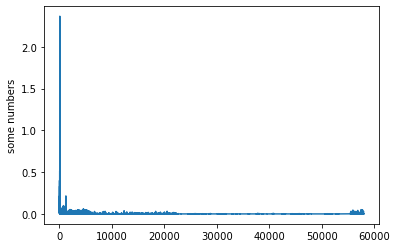

In [15]:
# d = fisher_information[0].flatten()
# index = np.arange(len(d))
# plt.bar(index, d)
# plt.ylabel('some numbers')
# plt.show()

d = [x.flatten() for x in fisher_information]
d = np.concatenate(d)

# d = a[0].flatten()
# index = np.arange(len(d))
# plt.bar(index, d)
plt.plot(d)
plt.ylabel('some numbers')
plt.show()

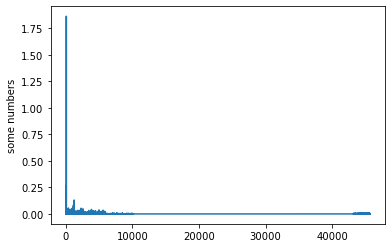

In [17]:
with open('mnist_fisher.npy', 'rb') as f:
    a = np.load(f, allow_pickle=True, encoding = 'latin1')

d = [x.flatten() for x in a]
d = np.concatenate(d)

# d = a[0].flatten()
# index = np.arange(len(d))
# plt.bar(index, d)
plt.plot(d)
plt.ylabel('some numbers')
plt.show()